In [270]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# import the data
current_dir = os.getcwd()
basics_dir_path = os.path.join(current_dir, 'data', 'section_1_basics')
team_box_scores_dir_path = os.path.join(current_dir, 'data', 'section_2_team_box_scores')
geography_dir_path = os.path.join(current_dir, 'data', 'section_3_geography')
public_rankings_dir_path = os.path.join(current_dir, 'data', 'section_4_public_rankings')
supplements_dir_path = os.path.join(current_dir, 'data', 'section_5_supplements')

In [271]:
dfs = {}
for path in [basics_dir_path, team_box_scores_dir_path, geography_dir_path, public_rankings_dir_path, supplements_dir_path]:
  for filename in os.listdir(path):
    if filename.endswith(".csv"):
      filepath = os.path.join(path, filename)
      df_name = filename[:-4]  # Remove the .csv extension
      dfs[df_name] = pd.read_csv(filepath)
dfs.keys()

dict_keys(['MNCAATourneyCompactResults', 'MNCAATourneySeeds', 'MRegularSeasonCompactResults', 'MSeasons', 'MTeams', 'WNCAATourneyCompactResults', 'WNCAATourneySeeds', 'WRegularSeasonCompactResults', 'WSeasons', 'WTeams', 'MNCAATourneyDetailedResults', 'MRegularSeasonDetailedResults', 'WNCAATourneyDetailedResults', 'WRegularSeasonDetailedResults', 'Cities', 'MGameCities', 'WGameCities', 'MMasseyOrdinals', 'Conferences', 'MConferenceTourneyGames', 'MNCAATourneySeedRoundSlots', 'MNCAATourneySlots', 'MSecondaryTourneyCompactResults', 'MSecondaryTourneyTeams', 'MTeamCoaches', 'MTeamConferences', 'MTeamSpellings', 'WConferenceTourneyGames', 'WNCAATourneySlots', 'WSecondaryTourneyCompactResults', 'WSecondaryTourneyTeams', 'WTeamConferences', 'WTeamSpellings'])

### In this model we are going to try some different methods and appraoches to see if we can get a better score and go a little more in depth

In [273]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_column", 999)
# we get a lot of errors messages because we are copying and moving dataframes. Check back later might be able to be removed with some changes
# limited the print output

In [274]:
# we should combnine men and womens data into one dataset matching the kaggle guidelines
M_regular_results = dfs['MRegularSeasonDetailedResults']
M_tourney_results = dfs['MNCAATourneyDetailedResults']
M_seeds = dfs['MNCAATourneySeeds']

W_regular_results = dfs['WRegularSeasonDetailedResults']
W_tourney_results = dfs['WNCAATourneyDetailedResults']
W_seeds = dfs['WNCAATourneySeeds']

In [275]:
regular_results = pd.concat([M_regular_results, W_regular_results])
tourney_results = pd.concat([M_tourney_results, W_tourney_results])
seeds = pd.concat([M_seeds, W_seeds])

In [276]:
# This is a lot of data little annoying to work with I think to stay relevant we will stick 
# to the more modern era lets say past 20 years
season = 2005
regular_results = regular_results.loc[regular_results["Season"] >= season]
tourney_results = tourney_results.loc[tourney_results["Season"] >= season]
seeds = seeds.loc[seeds["Season"] >= season]

In [277]:
# Print the first 5 rows of the combined tournament results
print("Tourney Results Header:")
print(tourney_results.head())

# Print the first 5 rows of the combined seed data
print("\nSeeds Data Header:")
print(seeds.head())

Tourney Results Header:
     Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
128    2005     134     1324      79     1105      69    N      0    29    57   
129    2005     136     1112      66     1429      53    N      0    23    49   
130    2005     136     1130      85     1335      65    N      0    30    52   
131    2005     136     1153      76     1234      64    N      0    27    57   
132    2005     136     1211      74     1457      64    N      0    27    59   

     WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  \
128      7     15    14    20   14   29    14   17     2     2   14    23   
129      6     14    14    18    9   24     9   11     3     6   12    20   
130      8     12    17    25    8   33    24   19     8     6   14    25   
131      9     18    13    22    9   27    18    8     5     8   19    20   
132      5     16    15    22   11   29    13   10     5     5   14    22   

     LFGA  LFGM3  LFGA3  L

In [278]:
# lets follow one team for a season
season = 2019
teamid = 1261

# Regular season results
r = regular_results.loc[
    (regular_results["Season"] == season)
    & ((regular_results["WTeamID"] == teamid) | (regular_results["LTeamID"] == teamid))
].copy()  # Make an explicit copy to avoid the SettingWithCopyWarning

# Tournament results
t = tourney_results.loc[
    (tourney_results["Season"] == season)
    & ((tourney_results["WTeamID"] == teamid) | (tourney_results["LTeamID"] == teamid))
].copy()  # Make an explicit copy to avoid the SettingWithCopyWarning

# Add win/lose column based on which team won
r.loc[:, "win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
t.loc[:, "win"] = np.where(t["WTeamID"] == teamid, "win", "lose")

# Add type column to distinguish between regular season and tournament games
r.loc[:, "type"] = "regular season"
t.loc[:, "type"] = "tournament"

# Combine regular season and tournament results into one DataFrame
rt = pd.concat([r, t])

# Display the relevant columns
print(rt[["DayNum", "WScore", "LScore", "type", "win"]])

# Check the seed for the team in the tournament for the 2024 season
team_seed = seeds.loc[(seeds["Season"] == season) & (seeds["TeamID"] == teamid)]
print(team_seed)

       DayNum  WScore  LScore            type   win
82074       1      94      63  regular season   win
82184       4      97      91  regular season   win
82360       8      85      76  regular season   win
82475      11      74      67  regular season   win
82791      17      67      55  regular season   win
82812      18      79      76  regular season  lose
82956      20      90      77  regular season  lose
83181      26      78      57  regular season   win
83499      34      91      50  regular season   win
83544      37      82      76  regular season  lose
83605      40      78      74  regular season   win
83844      46      75      57  regular season   win
83994      53      81      69  regular season   win
84439      64      88      79  regular season   win
84638      68      94      88  regular season   win
84763      71      83      69  regular season   win
84951      75      89      67  regular season   win
85125      79      92      82  regular season   win
85290      8

In [279]:
# Load MTeams data from the `dfs` dictionary
M_teams = dfs['MTeams']
M_teams.head()
teamid = 1261  # Replace with your desired TeamID

# Find the team name for the given TeamID
team_name = M_teams.loc[M_teams['TeamID'] == teamid, 'TeamName'].values[0]

print(f"Team name for TeamID {teamid}: {team_name}")

Team name for TeamID 1261: LSU


In [280]:
# very intuitive approach we saw mentioned in the kaggle forum and also suggested by chatgpt
# due to the data handling / submission format we should create a flipped duplicate entry
# this is so the model doesnt become over bias copmared to our last iteration
# i.e. before we put in and handled our data as team1ID_team2ID_team1Win%
# even though we randomized and mixed which team came first the model will still become
# bias that whichever team is presented first as team1 will win. 
# to solve this we should square our data i.e compare the odds of both
# team A vs team B, if team A wins we record team1won = 1
# team B vs team A, if team B wins we record team1won = 1
# this will help remove the bias and give a more balanced perspective to the model
# now the model is seeing the perspective from both teams if that makes sense
# a second major factor we didnt consider is the weight overtime has on points scored for a team

def prepare_data(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]
    
    # adjustment factor for overtimes, as more stats are accumulated during overtimes
    adjot = (40 + 5 * df["NumOT"]) / 40
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot    
    
    dfswap = df.copy()
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in list(df.columns)]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    output["win"] = (output["PointDiff"] > 0) * 1
    output["men_women"] = (output["T1_TeamID"].apply(lambda t: str(t).startswith("1"))) * 1  # 0: women, 1: men
    return output

# Apply the prepare_data function
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [281]:
print(regular_data.head())

   Season  DayNum  T2_TeamID  T2_Score  T1_TeamID  T1_Score  NumOT  T2_FGM  \
0    2005      10       1105      69.0       1128      79.0      0    22.0   
1    2005      10       1415      61.0       1143      78.0      0    22.0   
2    2005      10       1236      51.0       1206      69.0      0    20.0   
3    2005      10       1366      40.0       1272     102.0      0    16.0   
4    2005      10       1193      49.0       1280      53.0      0    15.0   

   T2_FGA  T2_FGM3  T2_FGA3  T2_FTM  T2_FTA  T2_OR  T2_DR  T2_Ast  T2_TO  \
0    59.0      7.0     22.0    18.0    27.0   12.0   21.0     8.0    8.0   
1    64.0      5.0     15.0    12.0    20.0   18.0   26.0    14.0   16.0   
2    59.0      4.0     17.0     7.0    10.0   13.0   23.0    11.0   16.0   
3    64.0      3.0     13.0     5.0     9.0   14.0   22.0     6.0   22.0   
4    51.0      3.0     17.0    16.0    19.0   13.0   23.0     8.0   11.0   

   T2_Stl  T2_Blk  T2_PF  T1_FGM  T1_FGA  T1_FGM3  T1_FGA3  T1_FTM  T1_FTA

In [282]:
print(tourney_data.head())

   Season  DayNum  T2_TeamID  T2_Score  T1_TeamID  T1_Score  NumOT  T2_FGM  \
0    2005     134       1105      69.0       1324      79.0      0    23.0   
1    2005     136       1429      53.0       1112      66.0      0    20.0   
2    2005     136       1335      65.0       1130      85.0      0    25.0   
3    2005     136       1234      64.0       1153      76.0      0    20.0   
4    2005     136       1457      64.0       1211      74.0      0    22.0   

   T2_FGA  T2_FGM3  T2_FGA3  T2_FTM  T2_FTA  T2_OR  T2_DR  T2_Ast  T2_TO  \
0    59.0     10.0     28.0    13.0    18.0   10.0   19.0    16.0   14.0   
1    55.0      7.0     19.0     6.0    10.0   12.0   20.0    15.0   12.0   
2    71.0     10.0     30.0     5.0    10.0   16.0   18.0    17.0   17.0   
3    59.0      5.0     17.0    19.0    25.0   16.0   27.0     5.0   11.0   
4    60.0     10.0     26.0    10.0    12.0   10.0   26.0    16.0   13.0   

   T2_Stl  T2_Blk  T2_PF  T1_FGM  T1_FGA  T1_FGM3  T1_FGA3  T1_FTM  T1_FTA

### Refer to our data breakdown from the previous assingment to help audience/others understand this data. Maybe use a simple graphic of box score data for basketball its a common way to store stats etc.

In [284]:
# Here we are just double checking that our "squared" df has the correct teams and information. checks out (:
# look at notes above for more context this is to help remove bias. Above is just taking in the regular season and playoff season stats
season = regular_data["Season"] == 2025
t1, t2 = 1182, 1433
match1 = (regular_data["T1_TeamID"] == t1) & (regular_data["T2_TeamID"] == t2)
match2 = (regular_data["T1_TeamID"] == t2) & (regular_data["T2_TeamID"] == t1)
regular_data.loc[season & (match1 | match2)]

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,PointDiff,win,men_women
109257,2025,120,1182,62.0,1433,71.0,0,21.0,51.0,4.0,16.0,16.0,24.0,11.0,19.0,9.0,15.0,8.0,5.0,16.0,23.0,55.0,8.0,22.0,17.0,21.0,12.0,22.0,10.0,14.0,9.0,4.0,23.0,9.0,1,1
300660,2025,120,1433,71.0,1182,62.0,0,23.0,55.0,8.0,22.0,17.0,21.0,12.0,22.0,10.0,14.0,9.0,4.0,23.0,21.0,51.0,4.0,16.0,16.0,24.0,11.0,19.0,9.0,15.0,8.0,5.0,16.0,-9.0,0,1


### Feature engineering

In [286]:
# starting with the easy stuff that we already tried like seed
# this time we will see if squaring the data helped to get us any improvement as suggested
# seed placement

# Extract seed data and to work with
seeds["seed"] = seeds["Seed"].apply(lambda x: int(x[1:3]))
print(seeds.head())

      Season Seed  TeamID  seed
1284    2005  W01    1449     1
1285    2005  W02    1448     2
1286    2005  W03    1211     3
1287    2005  W04    1257     4
1288    2005  W05    1210     5


In [287]:
# now we will see what impact see had on the win loss
# aka how did the seed difference impact how much high seed teams won by 
# and how bad the the low seed teams lose by
seeds_T1 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T2 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T1.columns = ["Season", "T1_TeamID", "T1_seed"]
seeds_T2.columns = ["Season", "T2_TeamID", "T2_seed"]

tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win", "men_women"]]
tourney_data = pd.merge(tourney_data, seeds_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, seeds_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]

print(tourney_data.head())

   Season  T1_TeamID  T2_TeamID  PointDiff  win  men_women  T1_seed  T2_seed  \
0    2005       1324       1105       10.0    1          1       16       16   
1    2005       1112       1429       13.0    1          1        3       14   
2    2005       1130       1335       20.0    1          1        4       13   
3    2005       1153       1234       12.0    1          1        7       10   
4    2005       1211       1457       10.0    1          1        3       14   

   Seed_diff  
0          0  
1         11  
2          9  
3          3  
4         11  


### We can see already that bigger seed differences lead to more points difference. Of course this is not a rule, we never know the outcome in sports but anything to help our model

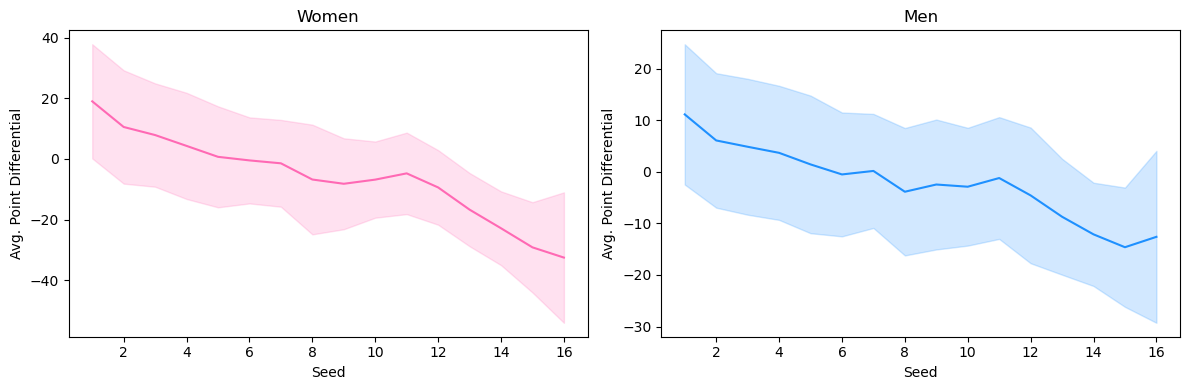

In [289]:
# Let's see if seed is predictive of point difference
tmpmean = tourney_data.pivot_table(columns="men_women", index="T1_seed", values="PointDiff", aggfunc="mean").ffill()
tmpstd = tourney_data.pivot_table(columns="men_women", index="T1_seed", values="PointDiff", aggfunc="std").ffill()

fig, axis = plt.subplots(ncols=2, figsize=(12, 4))

# Women (men_women == 0) in pink
(line_w,) = axis[0].plot(tmpmean.index, tmpmean[0], color="hotpink", linestyle='-')
fill_w = axis[0].fill_between(tmpmean.index, tmpmean[0] - tmpstd[0], tmpmean[0] + tmpstd[0], color="hotpink", alpha=0.2)
axis[0].set_title("Women")
axis[0].set_xlabel("Seed")
axis[0].set_ylabel("Avg. Point Differential")

# Men (men_women == 1) in blue
(line_m,) = axis[1].plot(tmpmean.index, tmpmean[1], color="dodgerblue", linestyle='-')
fill_m = axis[1].fill_between(tmpmean.index, tmpmean[1] - tmpstd[1], tmpmean[1] + tmpstd[1], color="dodgerblue", alpha=0.2)
axis[1].set_title("Men")
axis[1].set_xlabel("Seed")
axis[1].set_ylabel("Avg. Point Differential")

plt.tight_layout()
plt.show()

The visualization helps us see that the higher seed teams (more favored to win) usually have a point differential in their favor compared the the lower seeds, while the mid ground is a toss up. The upset is seeds 10-12 which are typically wild cards.

To give a little more context quick description of how the bracket works:
In NCAA basketball, 68 teams make the tournament each year, entering through two main paths:

🏆 1. Automatic Bids
32 teams receive automatic bids by winning their conference tournaments.

These teams are guaranteed a spot in the NCAA tournament regardless of their regular season record.

🃏 2. At-Large Bids (like "Wild Cards")
36 teams are chosen by the NCAA Selection Committee.

These are high-performing teams that did not win their conference tournaments but had strong seasons.

They’re often from tougher conferences or have impressive wins.

Though they didn’t earn an automatic bid, they’re still very competitive — sometimes even getting seeded as high as #1–#4.

At-large bids are essentially the NCAA’s version of wild card teams — strong teams that just didn’t clinch an auto-spot but are considered tournament-worthy.

🗺️ Tournament Structure & Seeding
The tournament is divided into 4 regions (e.g., East, West, Midwest, South).

Each region has teams seeded from #1 to #16 — with #1 being the strongest and #16 the weakest.

The First Four (play-in games) determines which of the lowest at-large and automatic qualifiers advance into the main bracket.

In most cases, higher seeds face lower seeds in early rounds (e.g., #1 vs #16, #2 vs #15), rewarding better-performing teams with theoretically easier matchups.

In [291]:
features = ["men_women", "T1_seed", "T2_seed","Seed_diff"]

In [292]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X = tourney_data[features]
y = tourney_data['win']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.3f}")

# Optional: Look at feature coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
})
print("\nFeature Coefficients:")
print(coefficients.sort_values('Coefficient', ascending=False))

Test Set Accuracy: 0.728

Feature Coefficients:
     Feature  Coefficient
3  Seed_diff     0.623136
2    T2_seed     0.494534
0  men_women     0.002992
1    T1_seed    -0.499157


We actually got a little worse score than before. I think this is because when squaring the data we got rid of the slight bias we had before but on par since we essentially used the same features.

In the below section we are going to use an N fold validation system

What we’re doing

Think of our seasons as “folds” in a cross‑validation scheme.

If we have S seasons of tournament data, it’s like performing an S‑fold CV.

Leave‑one‑season‑out

On each iteration, we pick one season (say 2005) to hold out entirely.

We train our model on all the other seasons (2006, 2007, …, 2024).

We then test it on the 2005 tournament games.

OOF (Out‑Of‑Fold) predictions

The predictions we make on that held‑out season are called out‑of‑fold predictions for that season.

We tag them with oof_season = 2005 so we know these came from a model that never saw any 2005 data.

Why we do it

It gives us a nearly unbiased estimate of how the model will perform on a brand‑new season.

By rotating through all seasons, we get OOF predictions (and accuracy or other metrics) for each season in turn.

Aggregating results

After looping through every season, we end up with one accuracy score per season.

We can then look at each season’s score (e.g. 68.8% on 2005) and compute an overall average accuracy across all seasons.

In [295]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

models = {}
oof_accuracy = []
oof_preds = []
oof_targets = []
oof_ss = []

# leave-one-season out models
for oof_season in set(tourney_data.Season):
    # X is your feature matrix
    X_train = tourney_data.loc[tourney_data["Season"] != oof_season, features].values
    # y should be your binary target (assuming something like 'Result' for win/loss)
    # If you're working with 'PointDiff', you might need to convert it to binary (e.g., > 0 means win)
    y_train = (tourney_data.loc[tourney_data["Season"] != oof_season, "PointDiff"] > 0).astype(int).values
    
    X_val = tourney_data.loc[tourney_data["Season"] == oof_season, features].values
    y_val = (tourney_data.loc[tourney_data["Season"] == oof_season, "PointDiff"] > 0).astype(int).values
    s_val = tourney_data.loc[tourney_data["Season"] == oof_season, "Season"].values
    
    # Create and train logistic regression model
    models[oof_season] = LogisticRegression(random_state=42, max_iter=1000)
    models[oof_season].fit(X_train, y_train)
    
    # Get predictions (probabilities)
    preds_proba = models[oof_season].predict_proba(X_val)[:, 1]
    # Get binary predictions
    preds_binary = models[oof_season].predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, preds_binary)
    print(f"oof season {oof_season} accuracy: {acc:.4f}")
    oof_accuracy.append(acc)
    oof_preds += list(preds_proba)
    oof_targets += list(y_val)
    oof_ss += list(s_val)
    
print(f"average accuracy: {np.mean(oof_accuracy):.4f}")

oof season 2005 accuracy: 0.6875
oof season 2006 accuracy: 0.6641
oof season 2007 accuracy: 0.7969
oof season 2008 accuracy: 0.7656
oof season 2009 accuracy: 0.7422
oof season 2010 accuracy: 0.7362
oof season 2011 accuracy: 0.6885
oof season 2012 accuracy: 0.7846
oof season 2013 accuracy: 0.7154
oof season 2014 accuracy: 0.7038
oof season 2015 accuracy: 0.7962
oof season 2016 accuracy: 0.6808
oof season 2017 accuracy: 0.7808
oof season 2018 accuracy: 0.7000
oof season 2019 accuracy: 0.7423
oof season 2021 accuracy: 0.7364
oof season 2022 accuracy: 0.6903
oof season 2023 accuracy: 0.7015
oof season 2024 accuracy: 0.7537
average accuracy: 0.7298


In [296]:
# pick a season to inspect
season = 2024

# 1) slice out your validation set for that season
val_df = tourney_data[tourney_data['Season'] == season].copy()

# 2) extract the feature matrix
X_val = val_df[features].values

# 3) get the model you trained for this season
clf = models[season]

# 4) compute win‑probabilities and binary preds
val_df['PredProb'] = clf.predict_proba(X_val)[:, 1]  # probability Team1 wins
val_df['PredWin']  = clf.predict(X_val).astype(int) # 1 if Team1 predicted to win

# 5) compute the actual outcome
val_df['ActualWin'] = (val_df['PointDiff'] > 0).astype(int)

# 6) select and print the key columns
out = val_df[[
    'Season',
    'T1_TeamID',
    'T2_TeamID',
    'PredProb',
    'PredWin',
    'ActualWin'
]].sort_values('PredProb', ascending=False)

#print(out.to_string(index=False))

In [297]:
# this name map contains both men and womens teams
# remeber our data set is squared it shows each game from both perspectives
# Every actual game appears twice in our validation fold: once as (T1→T2) and once as (T2→T1).

# means was imported up above if youre going to modularize this cell dont forget to include it
# or else you will get an error
W_teams = dfs['WTeams']

# 2) Build individual mappings
men_map   = dict(zip(M_teams['TeamID'], M_teams['TeamName']))
women_map = dict(zip(W_teams['TeamID'], W_teams['TeamName']))

# 3) Merge them (women’s names will overwrite only if there’s an ID collision)
name_map = {**men_map, **women_map}

# 4) Apply to your existing `out` DataFrame
named_out = out.copy()
named_out['T1_TeamName'] = named_out['T1_TeamID'].map(name_map)
named_out['T2_TeamName'] = named_out['T2_TeamID'].map(name_map)

# 5) Reorder/select the columns you want to display
named_out = named_out[[
    'Season',
    'T1_TeamName', 'T2_TeamName',
    'PredProb', 'PredWin', 'ActualWin'
]]

print(named_out.to_string(index=False))

 Season    T1_TeamName    T2_TeamName  PredProb  PredWin  ActualWin
   2024           Iowa     Holy Cross  0.942620        1          1
   2024         Purdue      Grambling  0.942620        1          1
   2024    Connecticut        Stetson  0.942620        1          1
   2024          Texas         Drexel  0.942620        1          1
   2024 South Carolina   Presbyterian  0.942620        1          1
   2024 North Carolina         Wagner  0.942620        1          1
   2024        Houston       Longwood  0.942620        1          1
   2024            USC TAM C. Christi  0.942620        1          1
   2024        Ohio St          Maine  0.918772        1          1
   2024      Tennessee     St Peter's  0.918772        1          1
   2024      Marquette            WKU  0.918772        1          1
   2024        Iowa St    S Dakota St  0.918772        1          1
   2024           UCLA    Cal Baptist  0.918772        1          1
   2024     Notre Dame           Kent  0.918772 

### Here we will now try more advanced feature enginering methods, and other models like xgboost

In [299]:
#!pip install xgboost
# you only need to run this cell once

In [300]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score

# 1) Set up your classification parameters
clf_params = {
    'objective': 'binary:logistic',
    'booster':   'gbtree',
    'eta':       0.01,
    'max_depth': 4,
    'subsample': 0.6,
    'colsample_bynode': 0.8,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'min_child_weight': 4,
    'max_bin': 32,
    'eval_metric': 'logloss'   # or 'error' for straight accuracy
}
num_rounds = 200  # you can adjust

# 2) Train OOF XGBClassifier
models_clf = {}
oof_acc    = []

for season in sorted(tourney_data['Season'].unique()):
    # split
    train_mask = tourney_data['Season'] != season
    val_mask   = tourney_data['Season'] == season

    X_train = tourney_data.loc[train_mask, features].values
    y_train = (tourney_data.loc[train_mask, 'PointDiff'] > 0).astype(int).values

    X_val   = tourney_data.loc[val_mask, features].values
    y_val   = (tourney_data.loc[val_mask, 'PointDiff'] > 0).astype(int).values

    # DMatrix with labels
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val,   label=y_val)

    # train classifier
    models_clf[season] = xgb.train(
        params       = clf_params,
        dtrain       = dtrain,
        num_boost_round = num_rounds
    )

    # predict & score
    preds_binary = (models_clf[season].predict(dval) > 0.5).astype(int)
    acc = accuracy_score(y_val, preds_binary)
    print(f"Season {season} XGBClassifier accuracy: {acc:.4f}")
    oof_acc.append(acc)

print(f"Average XGBClassifier accuracy: {np.mean(oof_acc):.4f}\n")

# 3) Inspect one season (e.g. 2024) just like before
season = 2024
val_df = tourney_data[tourney_data['Season']==season].copy()
X_val  = val_df[features].values

# get model, predict probabilities and class
clf = models_clf[season]
val_df['PredProb'] = clf.predict(xgb.DMatrix(X_val))
val_df['PredWin']  = (val_df['PredProb'] > 0.5).astype(int)
val_df['ActualWin'] = (val_df['PointDiff'] > 0).astype(int)

out = val_df[[
    'Season', 'T1_TeamID', 'T2_TeamID',
    'PredProb', 'PredWin', 'ActualWin'
]].sort_values('PredProb', ascending=False)

# map to names as before
men_map   = dict(zip(dfs['MTeams']['TeamID'], dfs['MTeams']['TeamName']))
women_map = dict(zip(dfs['WTeams']['TeamID'], dfs['WTeams']['TeamName']))
name_map  = {**men_map, **women_map}

named_out = out.copy()
named_out['T1_TeamName'] = named_out['T1_TeamID'].map(name_map)
named_out['T2_TeamName'] = named_out['T2_TeamID'].map(name_map)

named_out = named_out[[
    'Season',
    'T1_TeamName','T2_TeamName',
    'PredProb','PredWin','ActualWin'
]]

print(named_out.to_string(index=False))


Season 2005 XGBClassifier accuracy: 0.6875
Season 2006 XGBClassifier accuracy: 0.6641
Season 2007 XGBClassifier accuracy: 0.7969
Season 2008 XGBClassifier accuracy: 0.7656
Season 2009 XGBClassifier accuracy: 0.7422
Season 2010 XGBClassifier accuracy: 0.7362
Season 2011 XGBClassifier accuracy: 0.6885
Season 2012 XGBClassifier accuracy: 0.7846
Season 2013 XGBClassifier accuracy: 0.7154
Season 2014 XGBClassifier accuracy: 0.7038
Season 2015 XGBClassifier accuracy: 0.7962
Season 2016 XGBClassifier accuracy: 0.6808
Season 2017 XGBClassifier accuracy: 0.7808
Season 2018 XGBClassifier accuracy: 0.7000
Season 2019 XGBClassifier accuracy: 0.7423
Season 2021 XGBClassifier accuracy: 0.7364
Season 2022 XGBClassifier accuracy: 0.6903
Season 2023 XGBClassifier accuracy: 0.7015
Season 2024 XGBClassifier accuracy: 0.7537
Average XGBClassifier accuracy: 0.7298

 Season    T1_TeamName    T2_TeamName  PredProb  PredWin  ActualWin
   2024            USC TAM C. Christi  0.916021        1          1
   2024

We will give a little more of a break down into the MAE, features and their impact

In [302]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [303]:

# Start with an empty feature list and add features one by one
all_features = features.copy()  # Assuming 'features' contains all your feature names
feature_performance = {}

# For each iteration, add one more feature
for i in range(1, len(all_features) + 1):
    current_features = all_features[:i]
    feature_name = all_features[i-1]
    
    # Define your X and y
    X = tourney_data[current_features].values
    y = tourney_data["PointDiff"].values
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=50,  # Reduced for speed in iteration
        verbose_eval=False
    )
    
    # Evaluate
    predictions = model.predict(dtest)
    mae = mean_absolute_error(y_test, predictions)
    feature_performance[feature_name] = mae
    
    print(f"After adding feature {feature_name}, MAE: {mae}")

# Display overall performance trend
print("\nFeature Addition Performance:")
for feature, mae in feature_performance.items():
    print(f"{feature}: {mae}")

After adding feature men_women, MAE: 14.034857048370734
After adding feature T1_seed, MAE: 11.842647745515333
After adding feature T2_seed, MAE: 10.017948614803242
After adding feature Seed_diff, MAE: 10.058202974347333

Feature Addition Performance:
men_women: 14.034857048370734
T1_seed: 11.842647745515333
T2_seed: 10.017948614803242
Seed_diff: 10.058202974347333


In [304]:
# this was taken from the discussion forum it is a much better and refined xgboost
# they also use brier score which is a little more in line with the scenario slightly different
param = {}
param["objective"] = "reg:squarederror"
param["booster"] = "gbtree"
param["eta"] = 0.01
param["subsample"] = 0.6
param["colsample_bynode"] = 0.8
param["num_parallel_tree"] = 2
param["min_child_weight"] = 4
param["max_depth"] = 4
param["tree_method"] = "hist"
param['grow_policy'] = 'lossguide'
param["max_bin"] = 32

num_rounds = 700

In [305]:
from sklearn.metrics import mean_absolute_error, brier_score_loss

models = {}
oof_mae = []
oof_preds = []
oof_targets = []
oof_ss = []

# leave-one-season out models
for oof_season in set(tourney_data.Season):
    x_train = tourney_data.loc[tourney_data["Season"] != oof_season, features].values
    y_train = tourney_data.loc[tourney_data["Season"] != oof_season, "PointDiff"].values
    x_val = tourney_data.loc[tourney_data["Season"] == oof_season, features].values
    y_val = tourney_data.loc[tourney_data["Season"] == oof_season, "PointDiff"].values
    s_val = tourney_data.loc[tourney_data["Season"] == oof_season, "Season"].values
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)
    models[oof_season] = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round = num_rounds,        
    )
    preds = models[oof_season].predict(dval)
    print(f"oof season {oof_season} mae: {mean_absolute_error(y_val, preds)}")
    oof_mae.append(mean_absolute_error(y_val, preds))
    oof_preds += list(preds)
    oof_targets += list(y_val)
    oof_ss += list(s_val)
    
print(f"average mae: {np.mean(oof_mae)}")

oof season 2005 mae: 7.98657605190658
oof season 2006 mae: 9.246484904746628
oof season 2007 mae: 7.6775100705420805
oof season 2008 mae: 10.140076369978487
oof season 2009 mae: 8.792606936188207
oof season 2010 mae: 9.146973494519843
oof season 2011 mae: 9.746093704680092
oof season 2012 mae: 8.999011712935236
oof season 2013 mae: 10.912067202412418
oof season 2014 mae: 10.795952650522572
oof season 2015 mae: 8.514775584294245
oof season 2016 mae: 10.72589752100854
oof season 2017 mae: 10.416751203840423
oof season 2018 mae: 10.604279112854066
oof season 2019 mae: 9.293818674357526
oof season 2021 mae: 10.649404258867541
oof season 2022 mae: 10.783237922457271
oof season 2023 mae: 9.952391616345244
oof season 2024 mae: 9.617093959183835
average mae: 9.684263313244253


(quick chatgpt explenation)
Here’s how to read and explain those numbers:

“oof season XXXX mae: Y”

For each line, you held out the tournament games of season XXXX, trained your XGBoost model on all other seasons, then predicted the point differential (Team 1 score minus Team 2 score) for every game in that held‑out season.

Interpretation:

7.99 in 2005 means “on average we were off by about 8 points per game in that year’s tourney.”

10.14 in 2008 means “we missed by about 10 points per game” — so that season the model struggled a bit more.

Average MAE: 9.684

This is simply the mean of all the per‑season MAEs.

“Overall, across every season we tested, our model’s margin predictions are on average within about 9.7 points of the true spread.”

Why MAE matters here
Margin accuracy is crucial if you want to simulate brackets by score or plug spreads into betting models.

A lower MAE means your forecasted scores (and thus implied probabilities) are closer to reality.

Putting it in a report
XGBoost Margin Forecasting
Using leave‑one‑season‑out cross‑validation, our XGBoost regressor on “easy” features achieved:

Per‑season MAE ranging from ~7.7 (best in 2007) to ~10.9 (hardest in 2013), indicating some yearly variability in how predictable the tournaments were.

Average MAE ≈ 9.68, meaning our predicted point spreads miss the true differential by about 9–10 points on average.

Implications:

This sets a baseline for point‑spread accuracy.

Next steps could include adding advanced features (KenPom ratings, recent performance, etc.) to drive that MAE down—ideally into the 7–8 point range.

After margin forecasting, we’ll calibrate these predictions into win probabilities (via spline or Platt scaling) and evaluate them with Brier score to ensure our probability estimates are well‑tuned.

### Okay now that we explored the slight differences between logisitic regression, Xgboost, accuracy, MAE, and Brier Score lets look at more intense feature engineering and data enrichment

So above all we have done really is compare team seeds, and seed difference for our model lets incorporate more of the box features we were given

In [309]:
boxcols = [
    "T1_Score", "T1_FGM", "T1_FGA", "T1_FGM3", "T1_FGA3", "T1_FTM", "T1_FTA",
    "T1_OR", "T1_DR", "T1_Ast", "T1_TO", "T1_Stl", "T1_Blk", "T1_PF",
    "T2_Score", "T2_FGM", "T2_FGA", "T2_FGM3", "T2_FGA3", "T2_FTM", "T2_FTA",
    "T2_OR", "T2_DR", "T2_Ast", "T2_TO", "T2_Stl", "T2_Blk", "T2_PF",
    "PointDiff",
]

Here what we are doing is adding relevant team data into tournament data

 here is a more detailed write up taken from forum for how this section works
 
1. Let's define a single match {T, OPP}. This means that T=TEAM(x) plays against an opponent team OPP=TEAM(y1)
2. During regular season, team T plays multiple games {T, OPP1}, {T, OPP2}, ...; against different opponents OPP1=TEAM(y1), OPP2=TEAM(y2), ...
3. We can calculate regular season average performance for the team T : average[T]
4. We can also calculate how opponents perform on average when they play a game against team T : average[T_OPP1,T_OPP2,...]
5. Let's play a new match: {T1, T2}
6. We can collect performance data for the T1: average[T1] and average[T1_OPP1,T1_OPP2,...]
7. We can collect performance data for the T2: average[T2] and average[T2_OPP1,T2_OPP2,...]
8. Then we can combine all data: average[T1],average[T1_OPP1,T1_OPP2,...], average[T2], average[T2_OPP1,T2_OPP2,...]
9. Use this data to predict the output of a match between T1 and T2

In [311]:
ss = regular_data.groupby(["Season", "T1_TeamID"])[boxcols].agg("mean").reset_index()

ss_T1 = ss.copy()
ss_T1.columns = ["T1_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T1.columns)]
ss_T1 = ss_T1.rename({"T1_avg_Season": "Season", "T1_avg_TeamID": "T1_TeamID"}, axis=1)
ss_T2 = ss.copy()
ss_T2.columns = ["T2_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T2.columns)]
ss_T2 = ss_T2.rename({"T2_avg_Season": "Season", "T2_avg_TeamID": "T2_TeamID"}, axis=1)

tourney_data = pd.merge(tourney_data, ss_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, ss_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,men_women,T1_seed,T2_seed,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTM,T1_avg_FTA,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_opponent_Score,T1_avg_opponent_FGM,T1_avg_opponent_FGA,T1_avg_opponent_FGM3,T1_avg_opponent_FGA3,T1_avg_opponent_FTM,T1_avg_opponent_FTA,T1_avg_opponent_OR,T1_avg_opponent_DR,T1_avg_opponent_Ast,T1_avg_opponent_TO,T1_avg_opponent_Stl,T1_avg_opponent_Blk,T1_avg_opponent_PF,T1_avg_PointDiff,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTM,T2_avg_FTA,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_opponent_Score,T2_avg_opponent_FGM,T2_avg_opponent_FGA,T2_avg_opponent_FGM3,T2_avg_opponent_FGA3,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff
0,2005,1324,1105,10.0,1,1,16,16,0,69.984674,24.973180,55.934866,6.237548,18.681992,13.800766,20.850575,11.823755,20.570881,14.655172,12.003831,6.957854,2.475096,17.593870,73.141762,25.739464,54.681992,7.873563,21.429119,13.789272,19.463602,11.226054,22.977011,16.892720,13.666667,5.739464,2.681992,18.712644,-3.157088,68.402299,23.413793,58.444444,6.049808,20.065134,15.524904,25.283525,12.827586,24.134100,13.015326,15.160920,10.528736,3.831418,19.168582,67.145594,24.973180,59.141762,4.804598,16.747126,12.394636,19.272031,13.651341,27.850575,13.693487,19.900383,7.126437,3.636015,20.444444,1.256705
1,2005,1112,1429,13.0,1,1,3,14,11,79.269360,28.979798,61.461279,6.828283,16.936027,14.481481,18.592593,13.612795,23.094276,16.505051,14.723906,8.195286,3.555556,16.323232,69.154882,25.636364,58.400673,6.548822,19.060606,11.333333,16.936027,12.195286,20.606061,14.818182,16.858586,6.572391,2.457912,17.720539,10.114478,72.541935,26.658065,50.070968,5.709677,14.483871,13.516129,19.522581,9.406452,24.593548,17.141935,12.329032,5.535484,2.851613,13.548387,57.012903,21.109677,53.561290,6.083871,19.167742,8.709677,12.200000,10.006452,17.090323,10.090323,12.174194,6.335484,2.748387,17.045161,15.529032
2,2005,1130,1335,20.0,1,1,4,13,9,71.092857,25.231746,55.878571,3.966667,12.017460,16.662698,23.352381,14.221429,23.152381,17.138095,12.757143,7.184127,4.038095,14.722222,63.011905,23.600794,56.911905,6.138095,17.366667,9.672222,13.961905,12.267460,20.398413,13.219048,13.788095,6.741270,3.399206,19.426190,8.080952,67.916667,23.349206,53.444444,6.432540,18.841270,14.785714,22.337302,12.253968,24.952381,14.285714,15.511905,7.880952,3.194444,19.523810,60.281746,20.857143,52.527778,5.980159,18.373016,12.587302,19.837302,10.416667,21.892857,10.853175,15.813492,7.369048,3.257937,20.111111,7.634921
3,2005,1153,1234,12.0,1,1,7,10,3,75.929032,25.393548,57.683871,6.580645,18.851613,18.561290,26.793548,14.219355,26.877419,14.941935,13.380645,5.419355,6.806452,17.561290,63.967742,22.535484,60.877419,6.980645,20.464516,11.916129,17.838710,14.490323,21.606452,10.980645,14.148387,5.832258,2.187097,22.006452,11.961290,72.468750,25.385417,54.788194,6.333333,16.715278,15.364583,22.281250,10.954861,24.743056,15.343750,14.336806,7.465278,5.361111,18.454861,66.267361,23.625000,56.534722,6.166667,17.940972,12.850694,19.243056,11.850694,22.625000,13.756944,15.083333,6.836806,3.027778,19.454861,6.201389
4,2005,1211,1457,10.0,1,1,3,14,11,79.689655,27.586207,54.517241,5.034483,12.896552,19.482759,26.103448,11.724138,26.448276,15.827586,13.551724,5.586207,3.448276,17.413793,69.793103,24.620690,59.344828,8.413793,23.862069,12.137931,18.000000,11.517241,18.689655,15.586207,12.413793,5.931034,1.931034,21.620690,9.896552,66.222222,22.432950,51.091954,6.689655,18.521073,14.666667,21.413793,11.068966,23.291188,13.766284,13.858238,7.823755,3.727969,18.735632,58.517241,19.555556,49.141762,6.371648,19.318008,13.034483,19.731801,10.019157,21.091954,11.026820,14.881226,6.375479,1.992337,18.049808,7.704981
...,...,...,...,...,

In [312]:
dupe_cols = [col.replace('_x', '') for col in tourney_data.columns if '_x' in col]

for base in dupe_cols:
    col_x = base + '_x'
    col_y = base + '_y'
    if col_x in tourney_data.columns and col_y in tourney_data.columns:
        identical = (tourney_data[col_x] == tourney_data[col_y]).all()
        print(f"{base}: {'Identical' if identical else 'Different'}")

In [313]:
# run this if you have duplicates
# Drop all '_y' columns
#tourney_data = tourney_data.loc[:, ~tourney_data.columns.str.endswith('_y')]

# Remove '_x' suffix from remaining columns
#tourney_data.columns = [col.replace('_x', '') for col in tourney_data.columns]

In [314]:
# accidently ran the cell above too many time check for duplicates
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,men_women,T1_seed,T2_seed,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTM,T1_avg_FTA,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_opponent_Score,T1_avg_opponent_FGM,T1_avg_opponent_FGA,T1_avg_opponent_FGM3,T1_avg_opponent_FGA3,T1_avg_opponent_FTM,T1_avg_opponent_FTA,T1_avg_opponent_OR,T1_avg_opponent_DR,T1_avg_opponent_Ast,T1_avg_opponent_TO,T1_avg_opponent_Stl,T1_avg_opponent_Blk,T1_avg_opponent_PF,T1_avg_PointDiff,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTM,T2_avg_FTA,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_opponent_Score,T2_avg_opponent_FGM,T2_avg_opponent_FGA,T2_avg_opponent_FGM3,T2_avg_opponent_FGA3,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff
0,2005,1324,1105,10.0,1,1,16,16,0,69.984674,24.973180,55.934866,6.237548,18.681992,13.800766,20.850575,11.823755,20.570881,14.655172,12.003831,6.957854,2.475096,17.593870,73.141762,25.739464,54.681992,7.873563,21.429119,13.789272,19.463602,11.226054,22.977011,16.892720,13.666667,5.739464,2.681992,18.712644,-3.157088,68.402299,23.413793,58.444444,6.049808,20.065134,15.524904,25.283525,12.827586,24.134100,13.015326,15.160920,10.528736,3.831418,19.168582,67.145594,24.973180,59.141762,4.804598,16.747126,12.394636,19.272031,13.651341,27.850575,13.693487,19.900383,7.126437,3.636015,20.444444,1.256705
1,2005,1112,1429,13.0,1,1,3,14,11,79.269360,28.979798,61.461279,6.828283,16.936027,14.481481,18.592593,13.612795,23.094276,16.505051,14.723906,8.195286,3.555556,16.323232,69.154882,25.636364,58.400673,6.548822,19.060606,11.333333,16.936027,12.195286,20.606061,14.818182,16.858586,6.572391,2.457912,17.720539,10.114478,72.541935,26.658065,50.070968,5.709677,14.483871,13.516129,19.522581,9.406452,24.593548,17.141935,12.329032,5.535484,2.851613,13.548387,57.012903,21.109677,53.561290,6.083871,19.167742,8.709677,12.200000,10.006452,17.090323,10.090323,12.174194,6.335484,2.748387,17.045161,15.529032
2,2005,1130,1335,20.0,1,1,4,13,9,71.092857,25.231746,55.878571,3.966667,12.017460,16.662698,23.352381,14.221429,23.152381,17.138095,12.757143,7.184127,4.038095,14.722222,63.011905,23.600794,56.911905,6.138095,17.366667,9.672222,13.961905,12.267460,20.398413,13.219048,13.788095,6.741270,3.399206,19.426190,8.080952,67.916667,23.349206,53.444444,6.432540,18.841270,14.785714,22.337302,12.253968,24.952381,14.285714,15.511905,7.880952,3.194444,19.523810,60.281746,20.857143,52.527778,5.980159,18.373016,12.587302,19.837302,10.416667,21.892857,10.853175,15.813492,7.369048,3.257937,20.111111,7.634921
3,2005,1153,1234,12.0,1,1,7,10,3,75.929032,25.393548,57.683871,6.580645,18.851613,18.561290,26.793548,14.219355,26.877419,14.941935,13.380645,5.419355,6.806452,17.561290,63.967742,22.535484,60.877419,6.980645,20.464516,11.916129,17.838710,14.490323,21.606452,10.980645,14.148387,5.832258,2.187097,22.006452,11.961290,72.468750,25.385417,54.788194,6.333333,16.715278,15.364583,22.281250,10.954861,24.743056,15.343750,14.336806,7.465278,5.361111,18.454861,66.267361,23.625000,56.534722,6.166667,17.940972,12.850694,19.243056,11.850694,22.625000,13.756944,15.083333,6.836806,3.027778,19.454861,6.201389
4,2005,1211,1457,10.0,1,1,3,14,11,79.689655,27.586207,54.517241,5.034483,12.896552,19.482759,26.103448,11.724138,26.448276,15.827586,13.551724,5.586207,3.448276,17.413793,69.793103,24.620690,59.344828,8.413793,23.862069,12.137931,18.000000,11.517241,18.689655,15.586207,12.413793,5.931034,1.931034,21.620690,9.896552,66.222222,22.432950,51.091954,6.689655,18.521073,14.666667,21.413793,11.068966,23.291188,13.766284,13.858238,7.823755,3.727969,18.735632,58.517241,19.555556,49.141762,6.371648,19.318008,13.034483,19.731801,10.019157,21.091954,11.026820,14.881226,6.375479,1.992337,18.049808,7.704981
...,...,...,...,...,

In [315]:
# lets test this new performance

# Automatically gather features by excluding known non-feature columns
non_features = ['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'men_women']
features = [col for col in tourney_data.columns if col not in non_features]
# Start with an empty feature list and add features one by one
all_features = features.copy()  # Assuming 'features' contains all your feature names
feature_performance = {}

# For each iteration, add one more feature
for i in range(1, len(all_features) + 1):
    current_features = all_features[:i]
    feature_name = all_features[i-1]
    
    # Define your X and y
    X = tourney_data[current_features].values
    y = tourney_data["PointDiff"].values
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=50,  # Reduced for speed in iteration
        verbose_eval=False
    )
    
    # Evaluate
    predictions = model.predict(dtest)
    mae = mean_absolute_error(y_test, predictions)
    feature_performance[feature_name] = mae
    
    print(f"After adding feature {feature_name}, MAE: {mae}")

# Display overall performance trend
print("\nFeature Addition Performance:")
for feature, mae in feature_performance.items():
    print(f"{feature}: {mae}")

After adding feature T1_seed, MAE: 11.838630334862751
After adding feature T2_seed, MAE: 10.499841303976797
After adding feature Seed_diff, MAE: 10.560668377122175
After adding feature T1_avg_Score, MAE: 10.504923647671205
After adding feature T1_avg_FGM, MAE: 10.346288604939366
After adding feature T1_avg_FGA, MAE: 10.268873606205121
After adding feature T1_avg_FGM3, MAE: 10.255217042098193
After adding feature T1_avg_FGA3, MAE: 10.411169310145814
After adding feature T1_avg_FTM, MAE: 10.384992520545516
After adding feature T1_avg_FTA, MAE: 10.347932166745958
After adding feature T1_avg_OR, MAE: 10.27837075527006
After adding feature T1_avg_DR, MAE: 10.365454469919301
After adding feature T1_avg_Ast, MAE: 10.320313449699782
After adding feature T1_avg_TO, MAE: 10.196694381110976
After adding feature T1_avg_Stl, MAE: 10.160822174916097
After adding feature T1_avg_Blk, MAE: 10.17607910492662
After adding feature T1_avg_PF, MAE: 10.262359694474464
After adding feature T1_avg_opponent_Sco

We were able to get 1% better after that going from 10.05 MAE to 9.94, the key is that we can now try doing an elo system since we integrated the team stats into the tourney information

In [317]:
# Now we are trying an elo system with the previously enhanced data
# guide was in forums

# Function to update Elo ratings based on a match result
def update_elo(winner_elo, loser_elo):
    # Compute the expected chance the winner would win based on current ratings
    expected_win = expected_result(winner_elo, loser_elo)

    # Compute Elo change; greater if the win was unexpected
    change_in_elo = k_factor * (1 - expected_win)

    # Update ratings: winner gains, loser loses
    winner_elo += change_in_elo
    loser_elo -= change_in_elo

    return winner_elo, loser_elo


# Function to compute expected result of a match using Elo formula
def expected_result(elo_a, elo_b):
    # Returns a value between 0 and 1 representing the probability of elo_a winning
    return 1.0 / (1 + 10 ** ((elo_b - elo_a) / elo_width))


# Initial Elo rating for all teams
base_elo = 1000

# Elo width factor determines how rating differences translate into win probabilities
elo_width = 400

# K-factor controls how sensitive the ratings are to each game result
k_factor = 100

# Store Elo ratings for all teams across all seasons
elos = []

# Iterate through each season in the dataset
for season in sorted(set(seeds["Season"])):
    # Filter regular season games for this season
    ss = regular_data.loc[regular_data["Season"] == season]
    ss = ss.loc[ss["win"] == 1].reset_index(drop=True)  # Keep only games where win=1

    # Get all team IDs that played this season
    teams = set(ss["T1_TeamID"]) | set(ss["T2_TeamID"])

    # Initialize all teams with the base Elo rating
    elo = dict(zip(teams, [base_elo] * len(teams)))

    # Loop through each game in the regular season
    for i in range(ss.shape[0]):
        # Identify winning and losing teams in each game
        w_team, l_team = ss.loc[i, "T1_TeamID"], ss.loc[i, "T2_TeamID"]

        # Get current Elo ratings
        w_elo, l_elo = elo[w_team], elo[l_team]

        # Update Elo ratings based on the outcome
        w_elo_new, l_elo_new = update_elo(w_elo, l_elo)

        # Store updated ratings
        elo[w_team] = w_elo_new
        elo[l_team] = l_elo_new

    # Convert Elo ratings from dict to DataFrame for the current season
    elo = pd.DataFrame.from_dict(elo, orient="index").reset_index()
    elo = elo.rename({"index": "TeamID", 0: "elo"}, axis=1)
    elo["Season"] = season

    # Add to the list of Elo data
    elos.append(elo)

# Combine Elo ratings for all seasons into one DataFrame
elos = pd.concat(elos)

# Prepare Elo data for merging: one for team 1
elos_T1 = elos.copy().rename({"TeamID": "T1_TeamID", "elo": "T1_elo"}, axis=1)

# And another for team 2
elos_T2 = elos.copy().rename({"TeamID": "T2_TeamID", "elo": "T2_elo"}, axis=1)

# Merge Elo ratings into the tournament data
tourney_data = pd.merge(tourney_data, elos_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, elos_T2, on=["Season", "T2_TeamID"], how="left")

# Create a new feature: the Elo rating difference between the two teams
tourney_data["elo_diff"] = tourney_data["T1_elo"] - tourney_data["T2_elo"]


In [367]:
tourney_data
# so we added three new features

,Season,T1_TeamID,T2_TeamID,PointDiff,win,men_women,T1_seed,T2_seed,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTM,T1_avg_FTA,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_opponent_Score,T1_avg_opponent_FGM,T1_avg_opponent_FGA,T1_avg_opponent_FGM3,T1_avg_opponent_FGA3,T1_avg_opponent_FTM,T1_avg_opponent_FTA,T1_avg_opponent_OR,T1_avg_opponent_DR,T1_avg_opponent_Ast,T1_avg_opponent_TO,T1_avg_opponent_Stl,T1_avg_opponent_Blk,T1_avg_opponent_PF,T1_avg_PointDiff,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTM,T2_avg_FTA,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_opponent_Score,T2_avg_opponent_FGM,T2_avg_opponent_FGA,T2_avg_opponent_FGM3,T2_avg_opponent_FGA3,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_elo,T2_elo,elo_diff
0,2005,1324,1105,10.0,1,1,16,16,0,69.984674,24.973180,55.934866,6.237548,18.681992,13.800766,20.850575,11.823755,20.570881,14.655172,12.003831,6.957854,2.475096,17.593870,73.141762,25.739464,54.681992,7.873563,21.429119,13.789272,19.463602,11.226054,22.977011,16.892720,13.666667,5.739464,2.681992,18.712644,-3.157088,68.402299,23.413793,58.444444,6.049808,20.065134,15.524904,25.283525,12.827586,24.134100,13.015326,15.160920,10.528736,3.831418,19.168582,67.145594,24.973180,59.141762,4.804598,16.747126,12.394636,19.272031,13.651341,27.850575,13.693487,19.900383,7.126437,3.636015,20.444444,1.256705,1068.063307,976.476785,91.586522
1,2005,1112,1429,13.0,1,1,3,14,11,79.269360,28.979798,61.461279,6.828283,16.936027,14.481481,18.592593,13.612795,23.094276,16.505051,14.723906,8.195286,3.555556,16.323232,69.154882,25.636364,58.400673,6.548822,19.060606,11.333333,16.936027,12.195286,20.606061,14.818182,16.858586,6.572391,2.457912,17.720539,10.114478,72.541935,26.658065,50.070968,5.709677,14.483871,13.516129,19.522581,9.406452,24.593548,17.141935,12.329032,5.535484,2.851613,13.548387,57.012903,21.109677,53.561290,6.083871,19.167742,8.709677,12.200000,10.006452,17.090323,10.090323,12.174194,6.335484,2.748387,17.045161,15.529032,1409.774042,1327.061716,82.712326
2,2005,1130,1335,20.0,1,1,4,13,9,71.092857,25.231746,55.878571,3.966667,12.017460,16.662698,23.352381,14.221429,23.152381,17.138095,12.757143,7.184127,4.038095,14.722222,63.011905,23.600794,56.911905,6.138095,17.366667,9.672222,13.961905,12.267460,20.398413,13.219048,13.788095,6.741270,3.399206,19.426190,8.080952,67.916667,23.349206,53.444444,6.432540,18.841270,14.785714,22.337302,12.253968,24.952381,14.285714,15.511905,7.880952,3.194444,19.523810,60.281746,20.857143,52.527778,5.980159,18.373016,12.587302,19.837302,10.416667,21.892857,10.853175,15.813492,7.369048,3.257937,20.111111,7.634921,1288.914002,1246.982820,41.931182
3,2005,1153,1234,12.0,1,1,7,10,3,75.929032,25.393548,57.683871,6.580645,18.851613,18.561290,26.793548,14.219355,26.877419,14.941935,13.380645,5.419355,6.806452,17.561290,63.967742,22.535484,60.877419,6.980645,20.464516,11.916129,17.838710,14.490323,21.606452,10.980645,14.148387,5.832258,2.187097,22.006452,11.961290,72.468750,25.385417,54.788194,6.333333,16.715278,15.364583,22.281250,10.954861,24.743056,15.343750,14.336806,7.465278,5.361111,18.454861,66.267361,23.625000,56.534722,6.166667,17.940972,12.850694,19.243056,11.850694,22.625000,13.756944,15.083333,6.836806,3.027778,19.454861,6.201389,1237.307930,1239.048230,-1.740300
4,2005,1211,1457,10.0,1,1,3,14,11,79.689655,27.586207,54.517241,5.034483,12.896552,19.482759,26.103448,11.724138,26.448276,15.827586,13.551724,5.586207,3.448276,17.413793,69.793103,24.620690,59.344828,8.413793,23.862069,12.137931,18.000000,11.517241,18.689655,15.586207,12.413793,5.931034,1.931034,21.620690,9.896552,66.222222,22.432950,51.091954,6.689655,18.521073,14.666667,21.413793,11.068966,23.291188,13.766284,13.858238,7.823755,3.727969,18.735632,58.51724

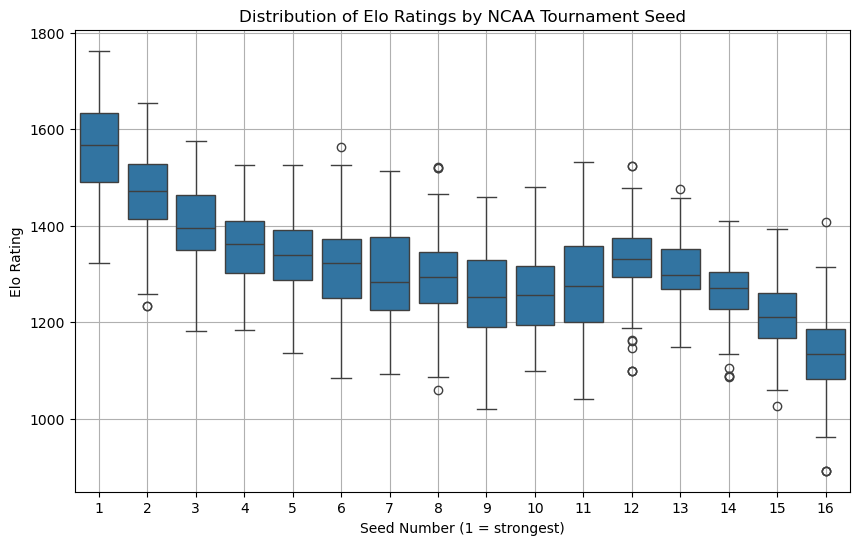

In [362]:
# Now plot Elo by seed
plt.figure(figsize=(10, 6))
seaborn.boxplot(data=tourney_data, x="T1_seed", y="T1_elo")
plt.title("Distribution of Elo Ratings by NCAA Tournament Seed")
plt.xlabel("Seed Number (1 = strongest)")
plt.ylabel("Elo Rating")
plt.grid(True)
plt.show()

Interesting we see a bump in the 10-12 seed elo

In [369]:
# lets test this new performance

# Automatically gather features by excluding known non-feature columns
non_features = ['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'men_women']
features = [col for col in tourney_data.columns if col not in non_features]
# Start with an empty feature list and add features one by one
all_features = features.copy()  # Assuming 'features' contains all your feature names
feature_performance = {}

# For each iteration, add one more feature
for i in range(1, len(all_features) + 1):
    current_features = all_features[:i]
    feature_name = all_features[i-1]
    
    # Define your X and y
    X = tourney_data[current_features].values
    y = tourney_data["PointDiff"].values
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=50,  # Reduced for speed in iteration
        verbose_eval=False
    )
    
    # Evaluate
    predictions = model.predict(dtest)
    mae = mean_absolute_error(y_test, predictions)
    feature_performance[feature_name] = mae
    
    print(f"After adding feature {feature_name}, MAE: {mae}")

# Display overall performance trend
print("\nFeature Addition Performance:")
for feature, mae in feature_performance.items():
    print(f"{feature}: {mae}")

After adding feature T1_seed, MAE: 11.838630334862751
After adding feature T2_seed, MAE: 10.499841303976797
After adding feature Seed_diff, MAE: 10.560668377122175
After adding feature T1_avg_Score, MAE: 10.504923647671205
After adding feature T1_avg_FGM, MAE: 10.346288604939366
After adding feature T1_avg_FGA, MAE: 10.268873606205121
After adding feature T1_avg_FGM3, MAE: 10.255217042098193
After adding feature T1_avg_FGA3, MAE: 10.411169310145814
After adding feature T1_avg_FTM, MAE: 10.384992520545516
After adding feature T1_avg_FTA, MAE: 10.347932166745958
After adding feature T1_avg_OR, MAE: 10.27837075527006
After adding feature T1_avg_DR, MAE: 10.365454469919301
After adding feature T1_avg_Ast, MAE: 10.320313449699782
After adding feature T1_avg_TO, MAE: 10.196694381110976
After adding feature T1_avg_Stl, MAE: 10.160822174916097
After adding feature T1_avg_Blk, MAE: 10.17607910492662
After adding feature T1_avg_PF, MAE: 10.262359694474464
After adding feature T1_avg_opponent_Sco

In [379]:
from sklearn.metrics import brier_score_loss

models = {}
oof_brier = []
oof_preds = []
oof_targets = []
oof_ss = []

# leave‑one‑season‑out models for binary win prediction
for oof_season in sorted(set(tourney_data.Season)):
    # Train on all seasons except the OOF one
    x_train = tourney_data.loc[tourney_data["Season"] != oof_season, features].values
    y_train = tourney_data.loc[tourney_data["Season"] != oof_season, "win"].values
    
    # Validate on the held‑out season
    x_val   = tourney_data.loc[tourney_data["Season"] == oof_season, features].values
    y_val   = tourney_data.loc[tourney_data["Season"] == oof_season, "win"].values
    s_val   = tourney_data.loc[tourney_data["Season"] == oof_season, "Season"].values
    
    # Construct DMatrix objects
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval   = xgb.DMatrix(x_val,   label=y_val)
    
    # Update your params for a binary classifier
    clf_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    
    # Train
    models[oof_season] = xgb.train(
        params=clf_params,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        verbose_eval=False
    )
    
    # Get predicted probabilities for “team1 wins”
    proba = models[oof_season].predict(dval)
    
    # Compute and record Brier score for this season
    brier = brier_score_loss(y_val, proba)
    print(f"OOF season {oof_season} Brier Score: {brier:.4f}")
    
    oof_brier += [brier]
    oof_preds  += list(proba)
    oof_targets+= list(y_val)
    oof_ss     += list(s_val)

# Overall average Brier
print(f"\nAverage Brier Score across seasons: {np.mean(oof_brier):.4f}")



OOF season 2005 Brier Score: 0.1927
OOF season 2006 Brier Score: 0.2677
OOF season 2007 Brier Score: 0.1531
OOF season 2008 Brier Score: 0.2038
OOF season 2009 Brier Score: 0.2530
OOF season 2010 Brier Score: 0.2304
OOF season 2011 Brier Score: 0.2431
OOF season 2012 Brier Score: 0.2100
OOF season 2013 Brier Score: 0.2294
OOF season 2014 Brier Score: 0.2257
OOF season 2015 Brier Score: 0.1508
OOF season 2016 Brier Score: 0.2562
OOF season 2017 Brier Score: 0.2179
OOF season 2018 Brier Score: 0.2339
OOF season 2019 Brier Score: 0.1699
OOF season 2021 Brier Score: 0.2409
OOF season 2022 Brier Score: 0.2176
OOF season 2023 Brier Score: 0.2129
OOF season 2024 Brier Score: 0.2052

Average Brier Score across seasons: 0.2165


According to this brier score were about 15% better than a random guess. The best methods that involved more complex techniques achieved brier scores of about .16 which is 36% better than random. The best technique however was combining a basic model with vegas betting lines. So a mix of man and machiene. Not exatly the best for DS though

https://www.kaggle.com/code/kaito510/goto-conversion-winning-solution